In [1]:
using_colab = True
if using_colab:
  from google.colab import drive
  drive.mount ('/content/gdrive', force_remount=True)
  !pip install rasterio rasterstats fiona geopandas earthpy earthengine-api -q
  import os
  os.chdir('/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/workflows')

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.0 MB/s eta 0:00:00


In [2]:
from osgeo import gdal
from osgeo import osr
from osgeo import ogr
#from flusstools.geotools import raster2array, get_srs, create_shp, make_prj, open_raster, raster2polygon, float2int
import geopandas as gpd
import pandas as pd
from rasterio import plot
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterstats import zonal_stats
import folium
import fiona
from rasterio.features import shapes
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
#import whitebox
os.chdir('/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites')

In [3]:
# Provide the path to your shapefile
shapefile_path = "current_data/field_gps.geojson"

# Read the shapefile using GeoPandas
data = gpd.read_file(shapefile_path)
data

,FGD_type,FGD_ID,District,Mining_site_GPS,FGD_GPS,Latitude,Longitude,geometry
0,Women,UGA0001,Kaabong,3.53269N;\n34.27366E,3.3157N; 34.1618E,3.532690,34.273660,POINT (34.27366 3.53269)
1,Women,UGA0001,Kaabong,3.53269N;\n34.27366E,3.3157N; 34.1618E,3.532690,34.273660,POINT (34.27366 3.53269)
2,Women,UGA0001,Kaabong,3.53269N;\n34.27366E,3.3157N; 34.1618E,3.532690,34.273660,POINT (34.27366 3.53269)
3,Women,UGA0001,Kaabong,3.53269N;\n34.27366E,3.3157N; 34.1618E,3.532690,34.273660,POINT (34.27366 3.53269)
4,Women,UGA0001,Kaabong,3.53269N;\n34.27366E,3.3157N; 34.1618E,3.532690,34.273660,POINT (34.27366 3.53269)
...,...,...,...,...,...,...,...,...
162,Mixed,UGA0014,Amudat,1.925211N;\n34.954624E,1.92511N 34.954624E,1.925211,34.954624,POINT (34.95462 1.92521)
163,Mixed,UGA0014,Amudat,1.925211N;\n34.954624E,1.92511N 34.954624E,1.925211,34.954624,POINT (34.95462 1.92521)
164,Mixed,UGA0014,Amudat,1.925211N;\n34.954624E,1.92511N 34.954624E,1.925211,34.954624,POINT (34.95462 1.92521)
165,Mixed,UGA0014,Amudat,1.925211N;\n34.954624E,1.92511N 34.954624E,1.925211,34.954624,POINT (34.95462 1.92521)


In [4]:
buffer_data = gpd.read_file('Mining_Buffered/Mining_Buffered.shp')
# Generate unique IDs for each feature
unique_ids = ['Min_site' + str(i) for i in range(1, len(buffer_data) + 1)]
# Assign the unique IDs to the 'mining_site_id' column
buffer_data['mining_site_id'] = unique_ids
buffer_data

,Site,Latitude,Longitude,geometry,mining_site_id
0,Kaabong1,3.532690,34.273660,"POLYGON ((34.31866 3.53269, 34.31646 3.51878, ...",Min_site1
1,Moroto1,2.405936,34.845722,"POLYGON ((34.89072 2.40594, 34.88852 2.39203, ...",Min_site2
2,Moroto2,2.650031,34.662469,"POLYGON ((34.70747 2.65003, 34.70527 2.63613, ...",Min_site3
3,Nakapiripirit1,2.030000,34.425500,"POLYGON ((34.47050 2.03000, 34.46830 2.01609, ...",Min_site4
4,Nakapiripirit2,1.920730,34.561800,"POLYGON ((34.60680 1.92073, 34.60460 1.90682, ...",Min_site5
5,Kaabong2,3.650640,34.308850,"POLYGON ((34.35385 3.65064, 34.35165 3.63673, ...",Min_site6
6,Moroto3,2.585147,34.677553,"POLYGON ((34.72255 2.58515, 34.72035 2.57124, ...",Min_site7
7,Amudat1,1.450433,34.787715,"POLYGON ((34.83272 1.45043, 34.83051 1.43653, ...",Min_site8
8,Amudat2,1.925211,34.954624,"POLYGON ((34.99962 1.92521, 34.99742 1.91131, ...",Min_site9


In [6]:

def crop_grid(tif_path,tile_id):
  # Open the TIFF file
  with rasterio.open(tif_path) as src:
      # Convert the polygon to the GeoJSON format
      geojson = mapping(polygon)

      # Crop the raster using the polygon
      cropped, _ = mask(src, [geojson], crop=True)

      # Get the unique classes and their counts
      unique_classes, class_counts = np.unique(cropped, return_counts=True)

      # Calculate the area of each class (in square meters) and round it off
      pixel_size = cropped.shape[1] * cropped.shape[2]  # Multiply pixel width by pixel height
      #print('pixel size:',cropped.shape[1],' * ',cropped.shape[2])
      class_areas = (class_counts * pixel_size)/ 1e6  # Multiply pixel width by pixel height and convert to square kilometers

  # Print the class labels and their corresponding areas
  for class_label, class_area in zip(unique_classes, class_areas):
      print("Class {}: {} km²".format(class_label, np.round(class_area,2)))
  return cropped



# Classification with Sentinel 2data

In [7]:
classification_2019 = gpd.read_file("karamoja_classification/.shp")

ERROR:fiona._env:karamoja_classification/.shp: No such file or directory


DriverError: karamoja_classification/.shp: No such file or directory

In [ ]:
classification_2019

,lulc_value,geometry
0,2,"POLYGON ((34.30558 3.69522, 34.30585 3.69522, ..."
1,2,"POLYGON ((34.30531 3.69513, 34.30549 3.69513, ..."
2,2,"POLYGON ((34.31367 3.69495, 34.31376 3.69495, ..."
3,2,"POLYGON ((34.31034 3.69495, 34.31043 3.69495, ..."
4,3,"POLYGON ((34.31043 3.69486, 34.31052 3.69486, ..."
...,...,...
166990,3,"POLYGON ((34.78942 1.40577, 34.78951 1.40577, ..."
166991,4,"POLYGON ((34.78627 1.40595, 34.78645 1.40595, ..."
166992,1,"POLYGON ((34.78717 1.40577, 34.78735 1.40577, ..."
166993,2,"POLYGON ((34.78429 1.49498, 34.78474 1.49498, ..."


<ipython-input-26-b41c1b8e213e>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


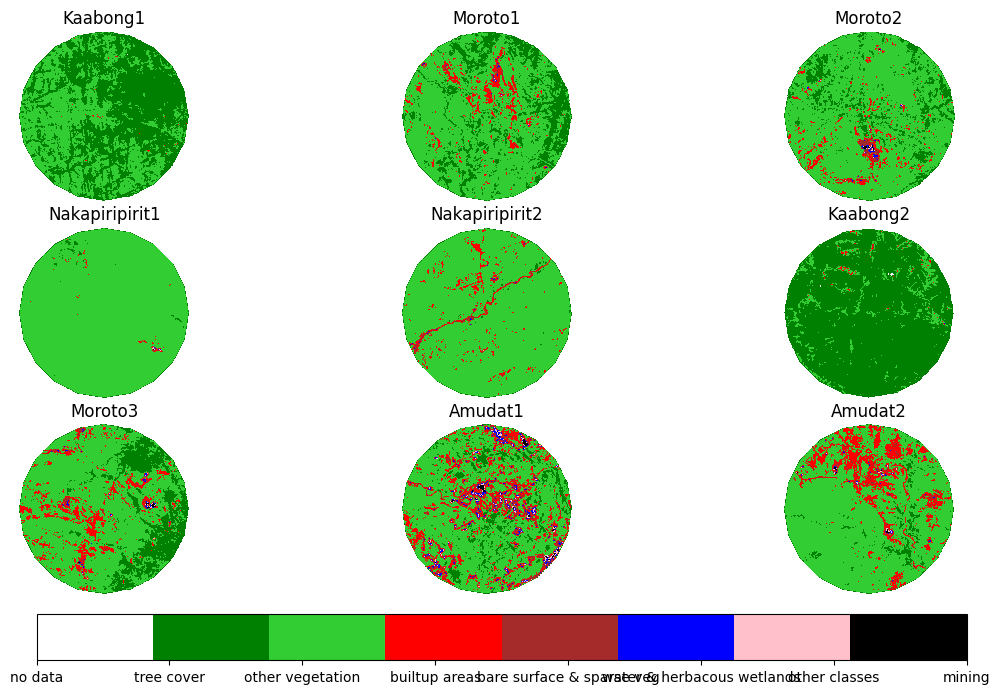

In [ ]:
# Path to the TIFF file
tif_path = r"sentinel_two_classification/2019/karamoja_Classified_2019.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data.geometry):
    # Crop the raster based on the polygon
    cropped = crop_grid(tif_path, tile_id=polygon)[0]

    # Define the coded colors for the classes
    class_colors = {
        0:'white', #no data
        1: 'green',           # tree cover
        2: 'limegreen',       # other vegetation
        3: 'red',             # built-up areas
        4: 'brown',            # bare surface and sparse vegetation
        5: 'blue',            # water and herbaceous wetlands
        6: 'pink',           # other classes
        7: 'black'           # mining
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the cropped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(cropped, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
    ax.set_title(buffer_data['Site'][idx])  # Set title with the site name from buffer_data
    ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['no data','tree cover', 'other vegetation', 'builtup areas', 'bare surface & sparse veg','water & herbacous wetlands','other classes','mining'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Path to the TIFF file
tif_path = r"sentinel_two_classification/2019/karamoja_Classified_2019.tif"

# Define the coded colors for the classes
class_colors = {
    0:'black', #no data
    1: 'green',           # tree cover
    2: 'limegreen',       # other vegetation
    3: 'red',             # built-up areas
    4: 'grey',            # bare surface and sparse vegetation
    5: 'blue',            # water and herbaceous wetlands
    6: 'pink',           # other classes
    7: 'orange'           # mining
}

# Create a custom colormap from the class colors
cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

# Open the TIFF file
with rasterio.open(tif_path) as src:
    classified_image = src.read(1)  # Read the first band (assuming the classes are stored in the first band)

fig, ax = plt.subplots(figsize=(14, 30))
im = ax.imshow(classified_image, cmap=cmap, vmin=1, vmax=len(class_colors))  # Use the custom colormap
ax.set_title("Classified Image 2015")  # Set a title
ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=range(1, len(class_colors) + 1), pad=0.1)
cbar.ax.set_xticklabels(['no data','tree cover', 'other vegetation', 'built-up areas', 'bare surface and sparse vegetation', 'water and herbaceous wetlands', 'other classes', 'mining'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# Path to the TIFF file
tif_path = r"current_data/mining_2015/classified_rf_2015_30trees.tif"

# Define the coded colors for the classes
class_colors = {
  1: 'green',        # tree cover
  2: 'limegreen',         # other_vegetation
  3: 'red',      # builtup areas
    4: 'grey',  # bare surface and sparse vegeation
5: 'blue',  # water and herbacous wetlands
  6: "white", #other classes
  7: "orange" #mining
}

# Create a custom colormap from the class colors
cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(tif_path, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
ax.set_title(buffer_data['Site'][idx])  # Set title with the site name from buffer_data
ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['tree cover', 'other vegetation', 'builtup areas', 'bare surface and sparse vegetation','water and herbacous wetlands','other classes','mining'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Classification with landsat 8 data

In [ ]:

#read the shapefiles
classification_2015 = gpd.read_file("current_data/mining_2015/classified_rf_2015_30_trees.shp")
classification_2020 = gpd.read_file("current_data/mining_2020/rf_2020_karamoja_class.shp")
classification_2023 = gpd.read_file("current_data/mining_2023/rf_2023_karamoja_class.shp")

In [ ]:
# Path to the TIFF file
tif_path = r"current_data/mining_2015/classified_rf_2015_30trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data.geometry):
    # Crop the raster based on the polygon
    cropped = crop_grid(tif_path, tile_id=polygon)[0]

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
          4: 'green',  # Vegetation
    5: 'blue'  # water
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the cropped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(cropped, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
    ax.set_title(buffer_data['Site'][idx])  # Set title with the site name from buffer_data
    ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the TIFF file
tif_path = r"updated_classification/karamoja/classifiedImage_rfSR_B3_SR_B4_SR_B5_SR_B6.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Crop the raster based on the polygon
    cropped = crop_grid(tif_path, tile_id=polygon)[0]

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
       4: 'green',  # Vegetation
    5: 'blue'  # water
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the cropped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(cropped, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
    ax.set_title(buffer_data_sorted['Site'].iloc[idx])  # Set title with the site name from buffer_data_sorted
    ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation',"water"])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

# Function to crop the raster and save it as GeoTIFF
def crop_and_save(tif_path, polygon, site_name):
    # Crop the raster based on the polygon
    cropped, transform = crop_grid(tif_path, tile_id=polygon)

    # Save the cropped raster as GeoTIFF
    output_tif_path = os.path.join("output_geoTIFF", f"{site_name}_cropped.tif")
    with rasterio.open(output_tif_path, 'w', driver='GTiff',
                       width=cropped.shape[1], height=cropped.shape[0],
                       count=1, dtype=cropped.dtype, crs=transform.crs,
                       transform=transform) as dst:
        dst.write(cropped, 1)

    return output_tif_path

# Function to convert polygon geometry to GeoDataFrame and save as ESRI shapefile
def geometry_to_shapefile(polygon, site_name):
    # Create a GeoDataFrame from the polygon geometry
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs=polygon.crs)

    # Save the GeoDataFrame as an ESRI shapefile
    output_shapefile_path = os.path.join("output_shapefile", f"{site_name}_polygon.shp")
    gdf.to_file(output_shapefile_path)

    return output_shapefile_path

# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the TIFF file
tif_path = r"updated_classification/karamoja/classifiedImage_rfSR_B3_SR_B4_SR_B5_SR_B6.tif"

# Create directories for output files if they don't exist
os.makedirs("output_geoTIFF", exist_ok=True)
os.makedirs("output_shapefile", exist_ok=True)

# Loop through each geometry and process
for idx, (polygon, site_name) in enumerate(zip(buffer_data_sorted.geometry, buffer_data_sorted['Site'])):
    # Crop the raster and save as GeoTIFF
    cropped_tif_path = crop_and_save(tif_path, polygon, site_name)

    # Convert polygon geometry to GeoDataFrame and save as ESRI shapefile
    shapefile_path = geometry_to_shapefile(polygon, site_name)

    print(f"Site '{site_name}' processed. GeoTIFF saved at '{cropped_tif_path}' and shapefile saved at '{shapefile_path}'.")


In [ ]:
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the TIFF file
tif_path = r"current_data/mining_2023/classifiedImage_gt_2023_20treesSR_B2_SR_B3_SR_B4_SR_B5_SR_B6_NDBI_NDVI_NDWI_SAVI_NBR.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Crop the raster based on the polygon
    cropped = crop_grid(tif_path, tile_id=polygon)[0]

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
        4: 'green'        # Vegetation
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the cropped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(cropped, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
    ax.set_title(buffer_data_sorted['Site'].iloc[idx])  # Set title with the site name from buffer_data_sorted
    ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the TIFF file
tif_path = r"current_data/mining_2023/classifiedImage_gt_2023_20treesSR_B2_SR_B3_SR_B4_SR_B5_SR_B6_SR_B7.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Crop the raster based on the polygon
    cropped = crop_grid(tif_path, tile_id=polygon)[0]

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
        4: 'green'        # Vegetation
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the cropped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(cropped, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)  # Use the custom colormap
    ax.set_title(buffer_data_sorted['Site'].iloc[idx])  # Set title with the site name from buffer_data_sorted
    ax.axis('off')  # Turn off the axis labels

# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
classifier = 'rf'
year =2023
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2023/"

# Get a list of all TIFF files in the folder
tif_files = r"classified_rf_2023_20trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]
    #print(site_name)
    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})

        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
        4: 'green',  # Vegetation
        5: 'blue'  # Vegetation
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
    # Save the clipped rasters as a shapefile
    clipped_rasters.to_file(shapefile_path)
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
classifier = 'smilecart'
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2023/"

# Get a list of all TIFF files in the folder
tif_files = r"classifiedImage_gt_2023_20treesSR_B2_SR_B3_SR_B4_SR_B5_SR_B6.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]

    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})

        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")
        #print(shapefile_path)
        #clipped_data.to_file(shapefile_path)

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
        4: 'green'  # Vegetation
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
# Save the clipped rasters as a shapefile
clipped_rasters.to_file(shapefile_path)
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
sh = gpd.read_file('/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/current_data/mining_2023/Amudat1_rf.shp')
sh

In [ ]:
classifier = 'rf'
year =2020
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2020/"

# Get a list of all TIFF files in the folder
tif_files = r"classified_rf_2020_30trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):

    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]

    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})
        print(clipped_data)
        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
        4: 'green',  # Vegetation
    5: 'blue'  # watern
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
    # Save the clipped rasters as a shapefile
    clipped_rasters.to_file(shapefile_path)
    break
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# with rasterio.open('/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/current_data/mining_2023/classified_rf_2023_20trees.tif') as src:
#     # Step 2: Convert raster to polygons
#     mask = src.read_masks(1)  # Read the mask layer of the raster
#     results = (
#         {'properties': {'raster_val': v}, 'geometry': s}
#         for i, (s, v) in enumerate(
#             shapes(mask, mask=(mask == 1), transform=src.transform)))

#     # Step 3: Write vector data
#     gdf = gpd.GeoDataFrame.from_features(list(results), crs=src.crs)
    #output_shapefile = "path/to/your/output/vector/file.shp"
    #gdf.to_file(output_shapefile)

In [ ]:
classifier = 'smilecart'
year =2020
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2020/"

# Get a list of all TIFF files in the folder
tif_files = r"classified_smilecart_2020_30trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]

    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})

        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
        4: 'green'  # Vegetation
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
# Save the clipped rasters as a shapefile
clipped_rasters.to_file(shapefile_path)
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
classifier = 'rf'
year =2015
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2020/"

# Get a list of all TIFF files in the folder
#tif_files = r"classified_smilecart_2015_30trees.tif"
tif_files =r"classified_rf_2020_30trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]

    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})

        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
        4: 'green',  # Vegetation
        5: 'blue'  # water
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
# Save the clipped rasters as a shapefile
clipped_rasters.to_file(shapefile_path)
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
classifier = 'rf'
year =2015
# Sort the DataFrame by the 'Site' column
buffer_data_sorted = buffer_data.sort_values(by='Site')

# Path to the folder containing the TIFF files
tif_path = r"current_data/mining_2015/"

# Get a list of all TIFF files in the folder
tif_files = r"classified_rf_2015_30trees.tif"

# Define the number of columns for plotting
num_columns = 3

# Calculate the number of rows needed based on the number of geometries and the number of columns
num_rows = math.ceil(len(buffer_data_sorted.geometry) / num_columns)

# Create a figure and axes for plotting
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))
clipped_rasters = gpd.GeoDataFrame(columns=['geometry', 'raster', 'site_name'])
# Loop through each geometry and plot them
for idx, polygon in enumerate(buffer_data_sorted.geometry):
    # Get the site name for the current polygon
    site_name = buffer_data_sorted['Site'].iloc[idx]

    # Open the corresponding TIFF file
    tif_path_ = os.path.join(tif_path, tif_files)
    with rasterio.open(tif_path_) as src:
        # Clip the raster based on the polygon
        out_image, out_transform = mask(src, [polygon], crop=True)

        # Vectorize the clipped raster
        clipped_data = gpd.GeoDataFrame(geometry=[polygon], data={'raster': [out_image]})

        # Save the clipped raster as a shapefile
        shapefile_path = os.path.join(tif_path, f"{site_name}_{classifier}.shp")

    # Define the coded colors for the classes
    class_colors = {
        0: [0, 0, 0],  # Black (for example, for class 0)
        1: 'grey',  # Bare
        2: 'red',  # Built-up areas
        3: 'yellow',  # Mining
         4: 'green',  # Vegetation
        5: 'blue'  # water
    }

    # Create a custom colormap from the class colors
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])

    # Plot the clipped raster
    row = idx // num_columns
    col = idx % num_columns
    ax = axes[row, col]
    im = ax.imshow(out_image[0], cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax.set_title(site_name)  # Set title with the site name
    ax.axis('off')  # Turn off the axis labels
# Save the clipped rasters as a shapefile
clipped_rasters.to_file(shapefile_path)
# Add colorbar at the top of the figure with custom tick labels
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', ticks=range(len(class_colors)), pad=-0.45)
cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
import glob
import geopandas as gpd
import os

# Define the path to the folder containing the shapefiles
folder_path = r'updated_classification/mining_sites_shapefiles/'

# Get a list of all shapefiles in the folder
shapefile_paths = sorted(glob.glob(folder_path + '/*.shp'))

# Define the site names based on the shapefile names
site_names = [os.path.splitext(os.path.basename(path))[0] for path in shapefile_paths]

# Read each shapefile into a separate DataFrame
sites = [gpd.read_file(path) for path in shapefile_paths]

# Perform any necessary operations on each DataFrame
lulc_names = ['bare', 'builtup_areas', 'mining', 'vegetation']

for site, name in zip(sites, site_names):
    site['lulc_name'] = site['classes'].replace([1, 2, 3, 4], lulc_names)
    print('i am heeeeeeeeeeeere')
    # Save each DataFrame as a GeoJSON file with the site name
    site.to_file(folder_path+f'{name}.geojson', driver='GeoJSON')


[]

In [ ]:
def create_folder(path):
  """
    Description:
      Create a folder in the given path
    Args:
      path(string): path
    Returns:
  """
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)
  if not isExist:
  # Create a new directory because it does not exist
    os.makedirs(path)
  else:
    pass

### Extract the area

In [ ]:
import re
# Function to create proportions
def create_proportion(rgb_img, data_path, proportion_path, year):
    count_ref_img1 = zonal_stats(data_path, rgb_img, categorical=True)
    stat_df_ = pd.DataFrame(count_ref_img1)
    geogrid = gpd.read_file(data_path)
    #print(geogrid.head())
    # Calculate the total LULC area for each feature
    geogrid['total_lulc_area'] = stat_df_[stat_df_.columns.to_list()[1:]].sum(axis=1)

    geogrid['total_lulc_area'] = geogrid['total_lulc_area']/ 10 #m2 to hectares


    # Identify columns for the given year
    columnsdate = [col for col in geogrid.columns.to_list()[1:] if str(year) in col]

    # Create a copy of the GeoDataFrame and fill NaN values with 0 for the selected columns
    gdfproportion = geogrid.copy()
    gdfproportion[columnsdate] = gdfproportion[columnsdate].fillna(0)

    # Calculate proportions for each selected column
    for i in columnsdate:
        gdfproportion[i] = gdfproportion[i] / gdfproportion['total_lulc_area']

    # Save the GeoDataFrame with proportions
    gdfproportion.to_file(proportion_path)

    return gdfproportion
def process_tif_file(class_path, rgb_img, grid_path, year):
    grid_data = gpd.read_file(grid_path)
    # Perform zonal statistics to count pixels by class
    ref_image = zonal_stats(grid_path, class_path, categorical=True)
    stat_df = pd.DataFrame(ref_image)
    stat_df = stat_df.sort_index(axis=1)

    all_possible_cols = [1, 2, 3, 4,5]
    missing_cols = list(set(all_possible_cols) - set(stat_df.columns))

    # Add missing columns with NaN values
    for col_ in missing_cols:
        stat_df[col_] = np.nan

    stat_df = stat_df.sort_index(axis=1)

    # Rename columns with a prefix based on the year
    init_cols = [str(year) + c for c in [ '_bare', '_builtup',  '_mining', '_water','_vegetation']]
    stat_df1 = stat_df.rename(columns=dict(zip(stat_df.columns, init_cols)))

    all_col = stat_df1.columns
    stat_df1 = stat_df1[all_col] / 100 #m2 to hectares
    #print(stat_df1.head(10))
    df = stat_df1
    #print(df.head())

    # Add grid data to the DataFrame
    df[grid_data.columns] = grid_data

    # Add data from "mining," "builtup," and "bareland" and create a new column
    df[f'{year}_mining_builtup'] = df[[f'{year}_mining', f'{year}_builtup']].sum(axis=1)

    # Drop the three individual columns
   # df.drop([f'{year}_mining', f'{year}_builtup', f'{year}_bareland'], axis=1, inplace=True)

    # Convert values to proportions (percentage)
    new_cols = df[[f'{year}_bare', f'{year}_builtup', f'{year}_mining', f'{year}_water', f'{year}_mining_builtup',f'{year}_vegetation']].columns
    #print(new_cols)
    out_path =folder_path+ f'/{site_name}_{year}_classification_version1'
    #Create folders if they don't exist
    create_folder(out_path)
    proportion_path = os.path.join(out_path, "lulc_proportion.geojson")
    operation = 'lulc'
    prop_data = create_proportion(rgb_img, grid_path, proportion_path, year)
   # print(prop_data)
    #print(prop_data.head())

    # Add proportions to the DataFrame and calculate proportions
    prop_data[new_cols] = df[new_cols]
    #print(prop_data.columns)
    for i in new_cols:
        prop_data[i] = prop_data[i] / prop_data['total_lulc_area']
    prop_data = prop_data.rename(columns={
      f'{year}_bare': f'{year}_bare',
      f'{year}_builtup': f'{year}_built',
      f'{year}_mining': f'{year}_minin',
      f'{year}_vegetation': f'{year}_veg',
      f'{year}_mining_builtup': f'{year}_min_built',
      f'{year}_water': f'{year}_water',
    })
    savepath1 = os.path.join(out_path, "dataframe")
    savepath2 = os.path.join(out_path, "dataframe")

    # Create folders if they don't exist
    create_folder(savepath1)
    create_folder(savepath2)

    # Add total LULC area to the DataFrame and save as CSV
    df['total_' + operation + '_area'] = prop_data['total_lulc_area']
    df.to_csv(os.path.join(savepath1, f'lulc_data_{year}.csv'))
    #df.head()
    #df.to_file(os.path.join(savepath1, f'edited_lulc_data_{year}.shp'))
    prop_data.to_csv(os.path.join(savepath2, f'lulc_prop_data_{year}.csv'))
    prop_data.to_file(os.path.join(savepath2, f'lulc_prop_data_{year}.shp'))

# Function to create folders if they don't exist
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Define the list of site paths
site_paths = [
    {'site_name': 'amudat_site_one', 'grid_path': 'Mining_Buffered/Site_Amudat1.geojson', 'folder_path': 'sentinel_two_classification/amudat_site_one/'},
    {'site_name': 'amudat_site_two', 'grid_path': 'Mining_Buffered/Site_Amudat2.geojson', 'folder_path': 'sentinel_two_classification/amudat_site_two/'},
    {'site_name': 'kaboong_site_one', 'grid_path': 'Mining_Buffered/Site_Kaabong1.geojson', 'folder_path': 'sentinel_two_classification/kaboong_site_one/'},
    {'site_name': 'kaboong_site_two', 'grid_path': 'Mining_Buffered/Site_Kaabong2.geojson', 'folder_path': 'sentinel_two_classification/kaboong_site_two/'},
    {'site_name': 'moroto_site_one', 'grid_path': 'Mining_Buffered/Site_Moroto1.geojson', 'folder_path': 'sentinel_two_classification/moroto_site_one/'},
    {'site_name': 'moroto_site_two', 'grid_path': 'Mining_Buffered/Site_Moroto2.geojson', 'folder_path': 'sentinel_two_classification/moroto_site_two/'},
    {'site_name': 'moroto_site_three', 'grid_path': 'Mining_Buffered/Site_Moroto3.geojson', 'folder_path': 'sentinel_two_classification/moroto_site_three/'},
    {'site_name': 'nakapiripirit_site_one', 'grid_path': 'Mining_Buffered/Site_Nakapiripirit1.geojson', 'folder_path': 'sentinel_two_classification/nakapiripirit_site_one/'},
    {'site_name': 'nakapiripirit_site_two', 'grid_path': 'Mining_Buffered/Site_Nakapiripirit2.geojson', 'folder_path': 'sentinel_two_classification/nakapiripirit_site_two/'},
]
site_path = 'sentinel_two_classification/'
for year in [ '2017','2019','2021','2023']:
    # Loop through each site path and process the data
  for site_info in site_paths:
      site_name = site_info['site_name']
      grid_path = site_info['grid_path']
      folder_path = site_info['folder_path']
      class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_v1_{year}.tif')
      rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
      process_tif_file(class_path, rgb_img, grid_path, year)


In [ ]:
def process_data_for_year(site_paths, year):
    dfs = []
    for site_info in site_paths:
        site_name = site_info['site_name']
        folder_path = site_info['folder_path']
        csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification_version1/dataframe/lulc_data_{year}.csv')

        if os.path.exists(csv_path):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(csv_path, index_col=0)
            # Add a column for the site name
            df['site_name'] = site_name
            # Append the DataFrame to the list
            dfs.append(df)
        else:
            print(f"CSV file not found: {csv_path}")

    # Concatenate all DataFrames into one
    combined_df = pd.concat(dfs, ignore_index=True)

    # Select specific columns if needed
    columns = ['site_name', 'Latitude', 'Longitude', 'geometry', 'total_lulc_area',
                f'{year}_bare',
                f'{year}_builtup',
                f'{year}_mining',
                f'{year}_mining_builtup',
                f'{year}_water',
                f'{year}_vegetation']
    combined_df = combined_df[columns]

    return combined_df

# Define the years to process
years = [2017,2019,2021, 2023]

# Process data for each year and store the results in a dictionary
data_frames = {year: process_data_for_year(site_paths, year) for year in years}

# Merge all DataFrames into one
combined_df = data_frames[2017]
for year in years[1:]:
    #year= 2017
    combined_df = combined_df.merge(data_frames[year], on=['site_name', 'Latitude', 'Longitude', 'geometry', 'total_lulc_area'], how='left')#, suffixes=('', f'{year}_'))
    combined_df.columns
# Optionally, save the combined DataFrame to a CSV file
combined_df.to_csv('combined_lulc_classification_version1.csv', index=False)

combined_df


,site_name,Latitude,Longitude,geometry,total_lulc_area,2017_bare,2017_builtup,2017_mining,2017_mining_builtup,2017_water,...,2021_mining,2021_mining_builtup,2021_water,2021_vegetation,2023_bare,2023_builtup,2023_mining,2023_mining_builtup,2023_water,2023_vegetation
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",7823.9,2802.40,1.03,120.96,121.99,NaN,...,56.34,71.06,NaN,3958.69,4207.18,156.02,70.86,226.88,NaN,3319.36
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",8616.4,4381.52,20.89,65.72,86.61,NaN,...,18.27,88.12,NaN,3326.78,3643.28,75.07,25.24,100.31,NaN,4010.99
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",8619.0,119.26,3.07,NaN,3.07,NaN,...,NaN,0.23,NaN,7371.12,4.11,0.43,0.01,0.44,NaN,7749.96
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",8615.9,4.88,0.66,0.02,0.68,NaN,...,NaN,0.10,NaN,7663.45,3.60,1.80,0.13,1.93,NaN,7748.99
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",8616.3,3045.54,54.94,16.22,71.16,NaN,...,4.89,20.99,NaN,4151.31,2366.84,58.78,19.38,78.16,NaN,5309.57
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",8616.2,3738.25,52.45,19.95,72.40,NaN,...,38.42,46.82,0.59,3757.94,3074.77,57.27,48.72,105.99,0.27,4572.31
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",8616.3,3582.71,91.16,27.44,118.60,NaN,...,13.08,55.55,NaN,2831.43,2417.28,138.47,18.49,156.96,NaN,5180.29
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",8611.8,1016.29,18.54,0.56,19.10,NaN,...,NaN,2.09,NaN,7533.37,2.54,0.11,0.03,0.14,NaN,7750.76
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",8615.2,2690.40,9.13,73.52,82.65,0.45,...,56.55,96.76,NaN,4534.89,638.51,33.18,48.82,82.00,0.45,7033.50


In [ ]:
# Melt the dataframe to create 'variable' and 'area' columns and extract the year
melted_df = combined_df.melt(id_vars=['site_name', 'Latitude', 'Longitude', 'geometry', 'total_lulc_area'],
                             var_name='lulc_name', value_name='area_ha')

# Extract year from the 'variable' column
melted_df['year'] = melted_df['lulc_name'].str.extract(r'(\d{4})')

# Dropping the year from the 'variable' column
melted_df['lulc_name'] = melted_df['lulc_name'].str.extract('_(.*)')

# Display the first few rows of the transformed dataframe
melted_df.to_csv('version_one_Karamoja_lulc_classification.csv', index=False)

In [ ]:
melted_df

,site_name,Latitude,Longitude,geometry,total_lulc_area,lulc_name,area_ha,year
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",7823.9,bare,2802.40,2017
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",8616.4,bare,4381.52,2017
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",8619.0,bare,119.26,2017
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",8615.9,bare,4.88,2017
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",8616.3,bare,3045.54,2017
...,...,...,...,...,...,...,...,...
211,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",8616.3,vegetation,5309.57,2023
212,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",8616.2,vegetation,4572.31,2023
213,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",8616.3,vegetation,5180.29,2023
214,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",8611.8,vegetation,7750.76,2023


In [ ]:
melted_df.lulc_name.unique()

array(['bare', 'builtup', 'mining', 'mining_builtup', 'water',
       'vegetation'], dtype=object)

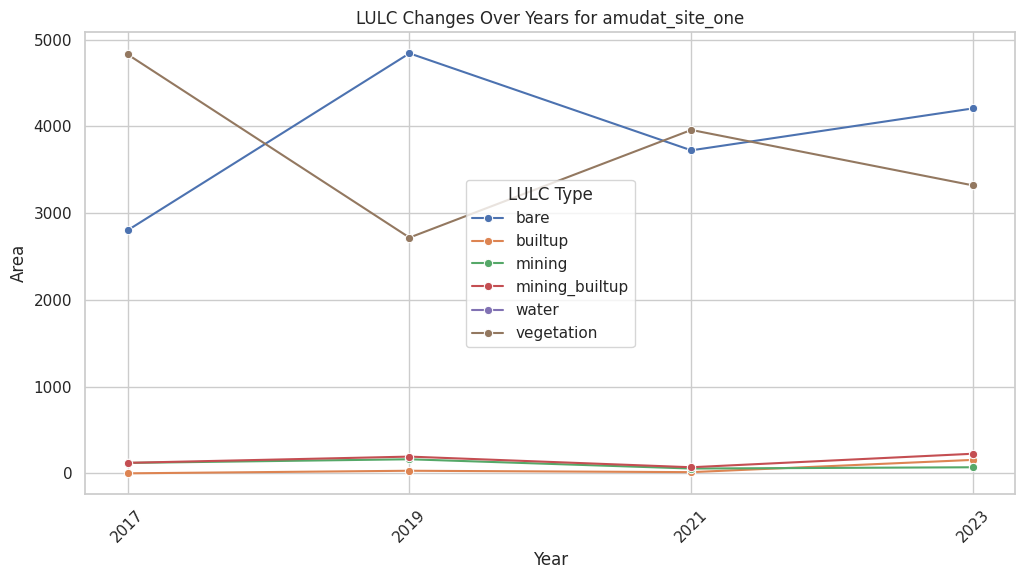

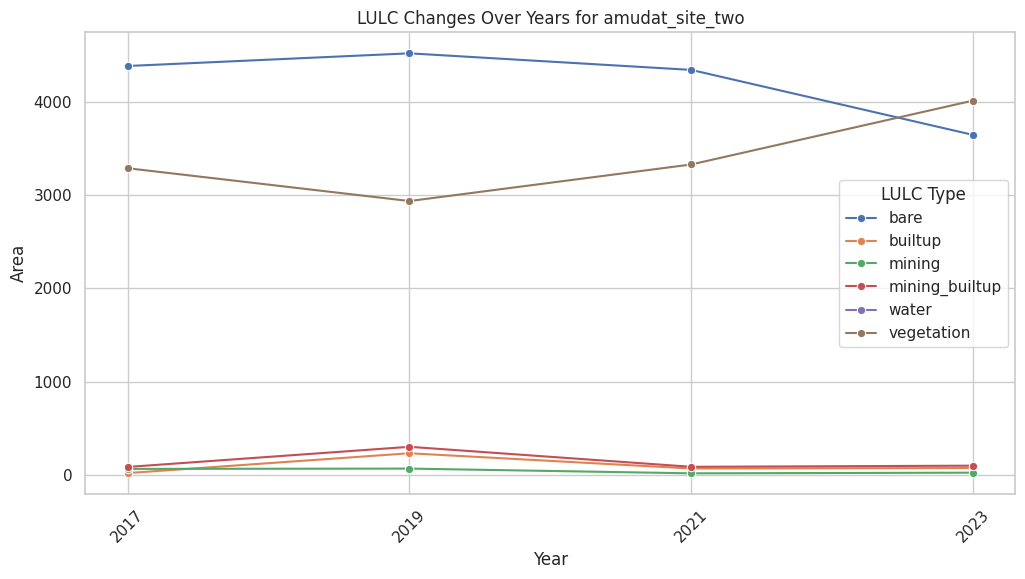

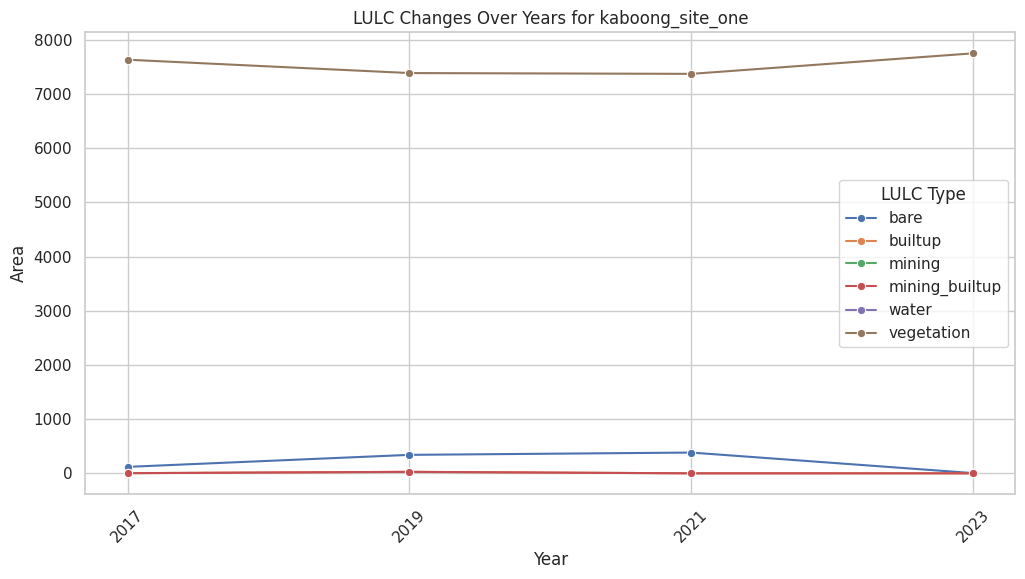

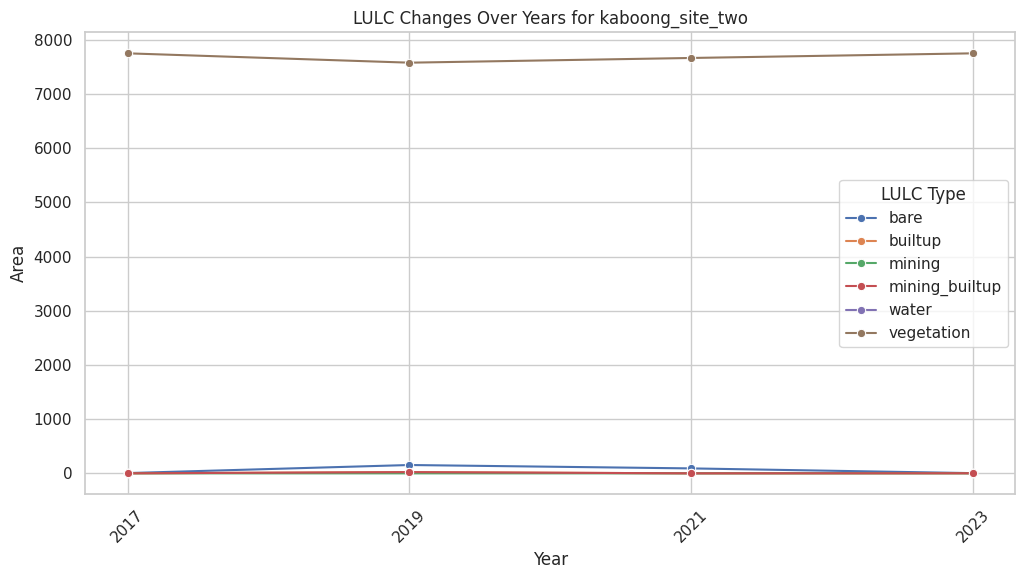

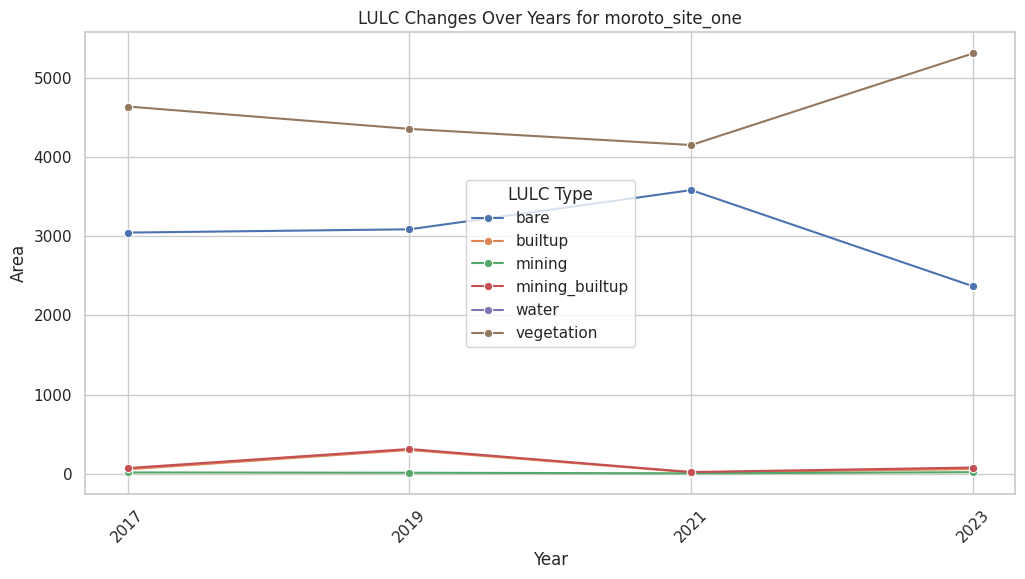

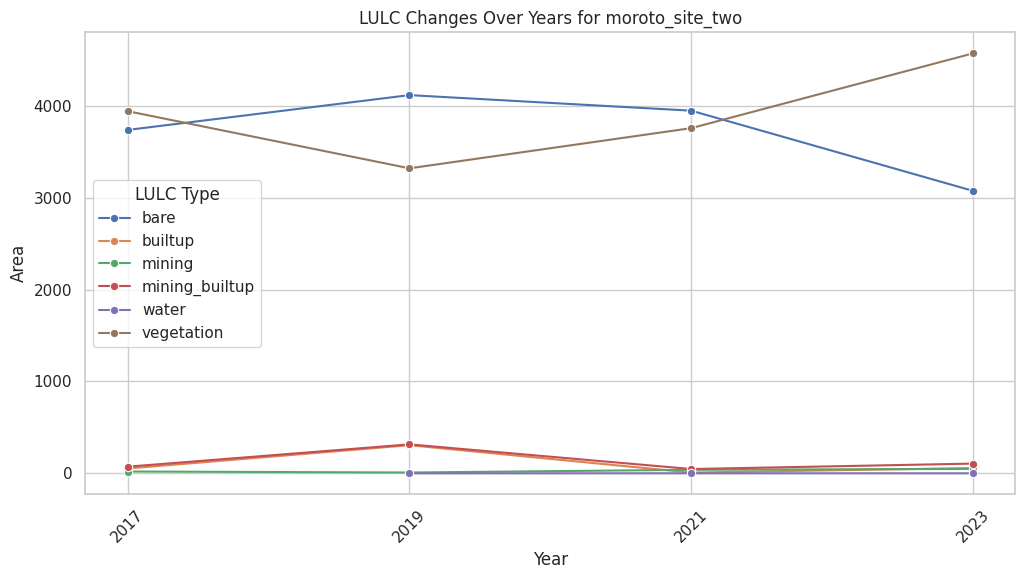

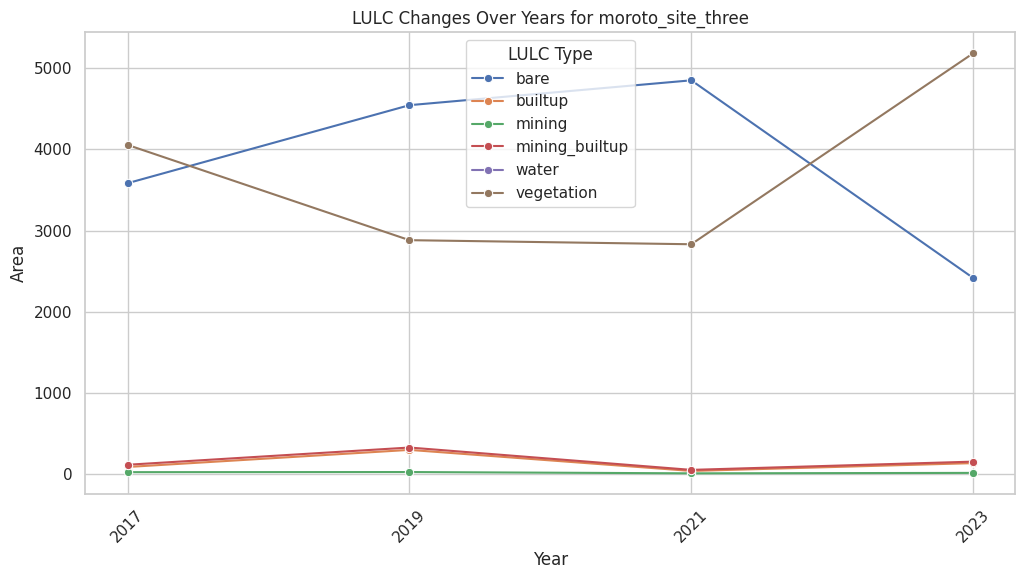

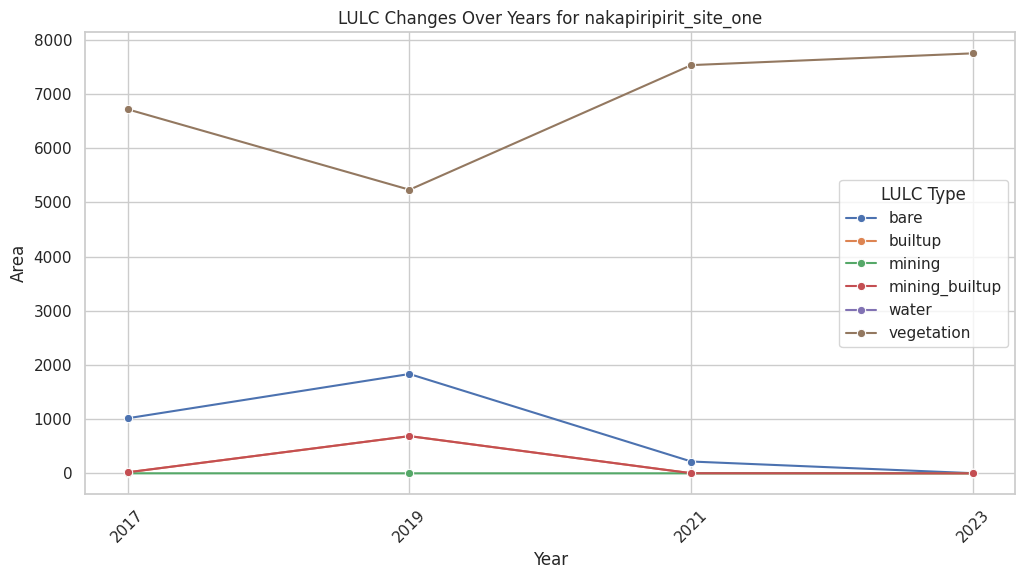

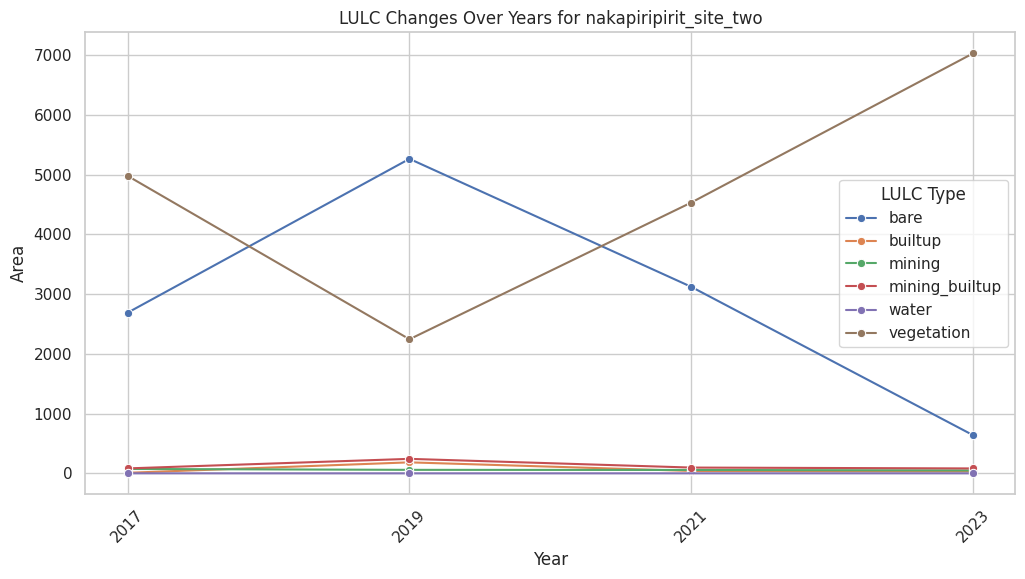

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot LULC changes for each site
sns.set(style='whitegrid')

# Get unique sites
unique_sites = melted_df['site_name'].unique()

# Create a plot for each site
for site in unique_sites:
    site_data = melted_df[melted_df['site_name'] == site]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=site_data, x='year', y='area_ha', hue='lulc_name', marker='o')
    plt.title(f'LULC Changes Over Years for {site}')
    plt.xlabel('Year')
    plt.ylabel('Area')
    plt.legend(title='LULC Type')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


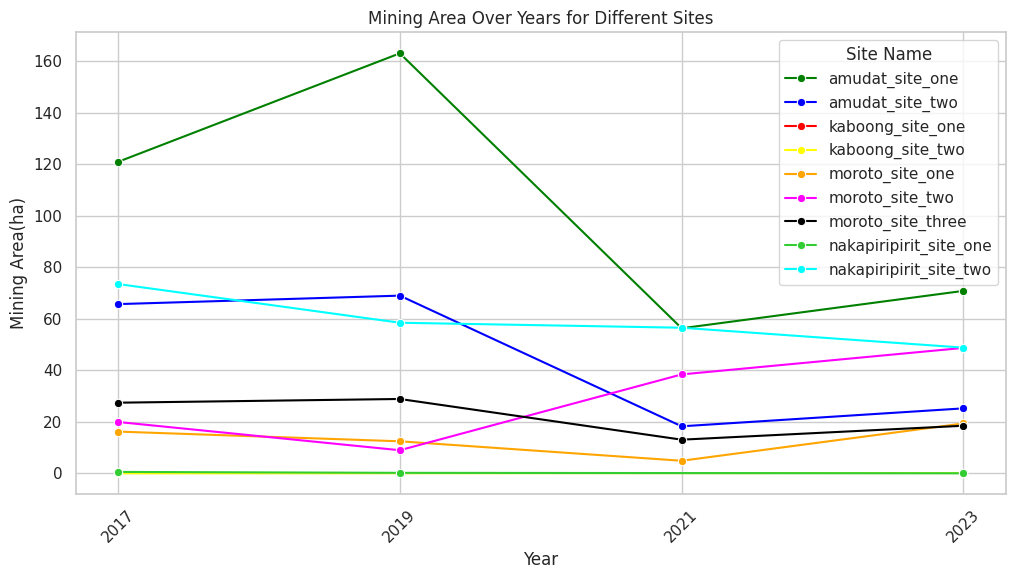

In [ ]:
# Plot mining area changes for each site
plt.figure(figsize=(12, 6))
mining_df = melted_df[melted_df['lulc_name'] == 'mining']
# Define the custom color palette
palette = ['green', 'blue', 'red', 'yellow', 'orange', 'magenta','black','limegreen','cyan']

sns.lineplot(data=mining_df, x='year', y='area_ha', hue='site_name', marker='o', palette=palette)
plt.title('Mining Area Over Years for Different Sites')
plt.xlabel('Year')
plt.ylabel('Mining Area(ha)')
plt.legend(title='Site Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


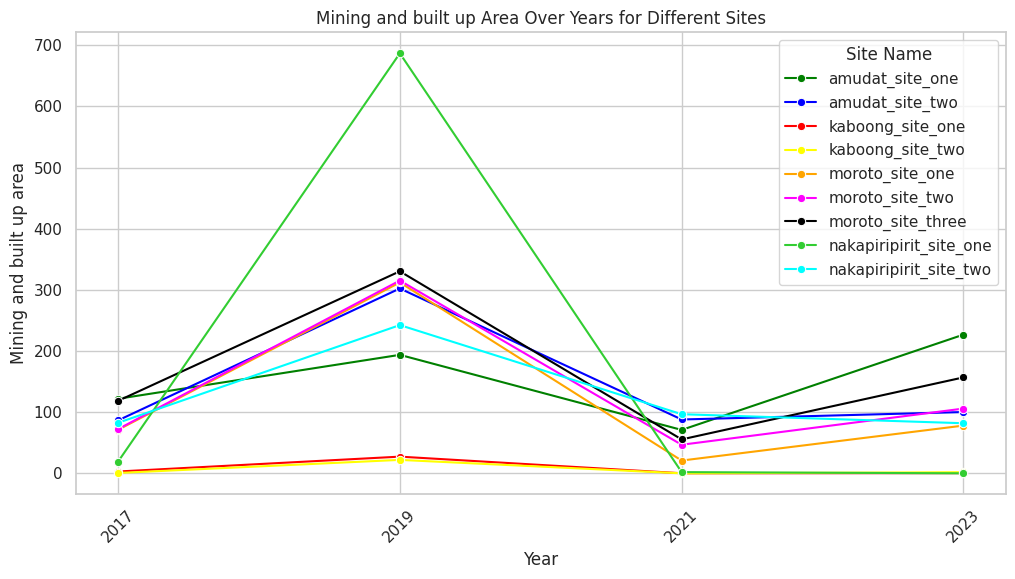

In [ ]:
# Plot mining area changes for each site
plt.figure(figsize=(12, 6))
mining_built_df = melted_df[melted_df['lulc_name'] == 'mining_builtup']
# Define the custom color palette
palette = ['green', 'blue', 'red', 'yellow', 'orange', 'magenta','black','limegreen','cyan']

sns.lineplot(data=mining_built_df, x='year', y='area_ha', hue='site_name', marker='o', palette=palette)
plt.title('Mining and built up Area Over Years for Different Sites')
plt.xlabel('Year')
plt.ylabel('Mining and built up area (ha)')
plt.legend(title='Site Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

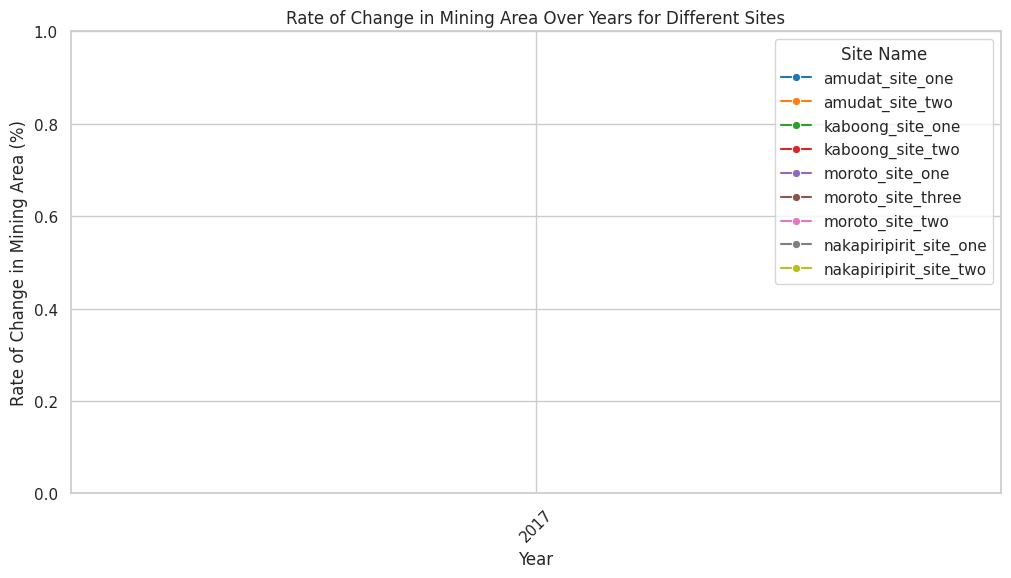

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mining_df is your DataFrame and contains columns 'site_name', 'year', and 'area_ha'

# Sort by site name and year
mining_df = mining_df.sort_values(by=['site_name', 'year'])

# Calculate the rate of change based on the first year (2017)
base_year = 2017
mining_df['base_area'] = mining_df[mining_df['year'] == base_year].set_index('site_name')['area_ha']
mining_df['base_area'] = mining_df['site_name'].map(mining_df['base_area'])
mining_df['rate_of_change'] = (mining_df['area_ha'] - mining_df['base_area']) / mining_df['base_area'] * 100

# Plot the rate of change for mining area changes for each site
plt.figure(figsize=(12, 6))
sns.lineplot(data=mining_df, x='year', y='rate_of_change', hue='site_name', marker='o', palette='tab10')
plt.title('Rate of Change in Mining Area Over Years for Different Sites')
plt.xlabel('Year')
plt.ylabel('Rate of Change in Mining Area (%)')
plt.legend(title='Site Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


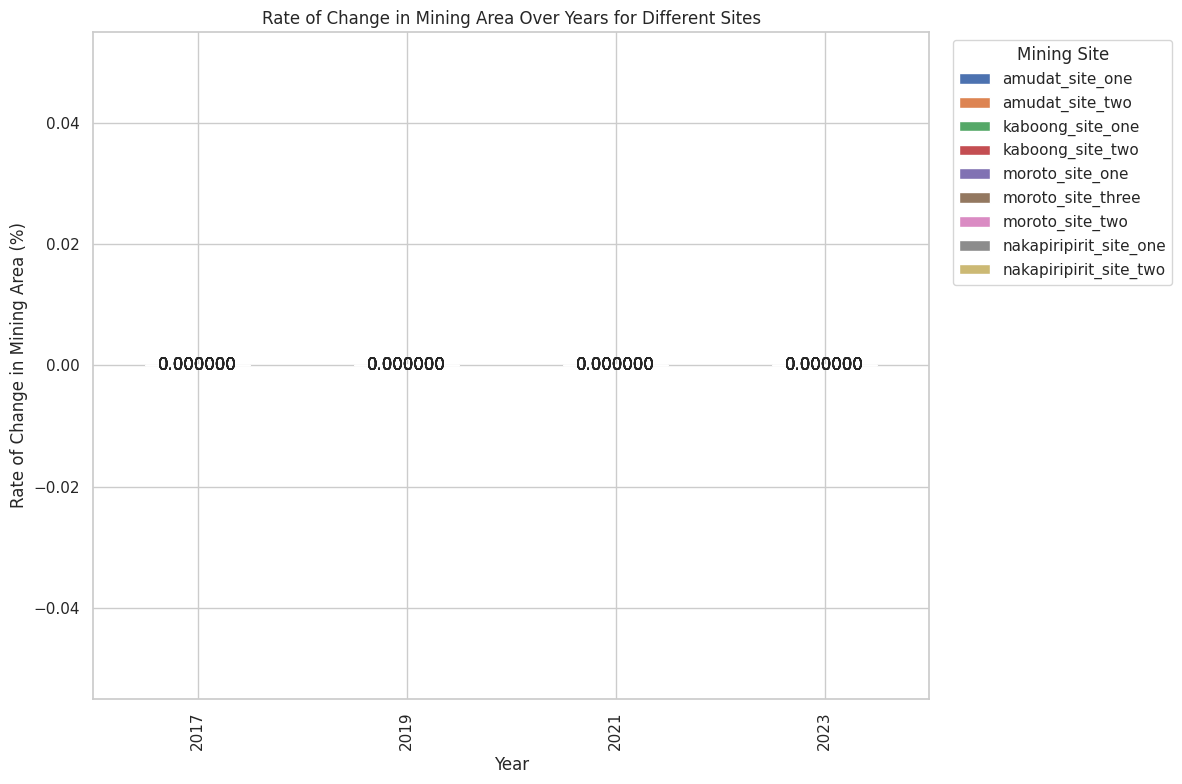

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming mining_df is your DataFrame with columns 'site_name', 'year', 'rate_of_change'

# Pivot the data to create a matrix suitable for stacked bar chart
pivot_df = mining_df.pivot(index='year', columns='site_name', values='rate_of_change')

# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))

# Customize the plot
ax.set_title('Rate of Change in Mining Area Over Years for Different Sites')
ax.set_xlabel('Year')
ax.set_ylabel('Rate of Change in Mining Area (%)')
ax.legend(title='Mining Site', loc='upper left', bbox_to_anchor=(1.02, 1))
ax.grid(True, axis='y')

# Add data labels to each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.6f}', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()
plt.show()

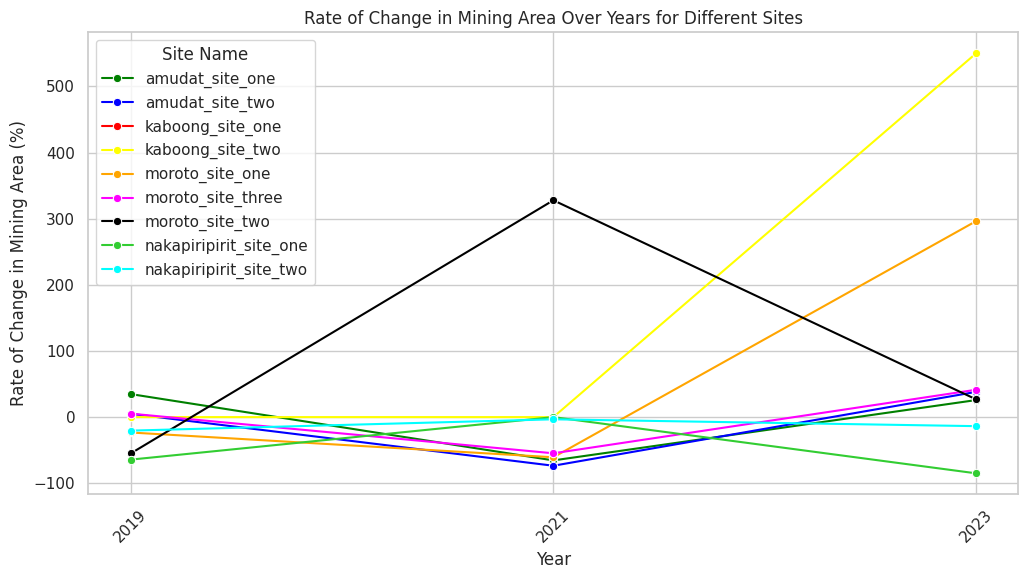

In [ ]:
# Sort by site name and year
mining_df = mining_df.sort_values(by=['site_name', 'year'])

# Calculate the rate of change of mining area
mining_df['rate_of_change'] = mining_df.groupby('site_name')['area_ha'].pct_change() * 100

# Plot the rate of change for mining area changes for each site
plt.figure(figsize=(12, 6))
sns.lineplot(data=mining_df, x='year', y='rate_of_change', hue='site_name', marker='o',palette=palette)
plt.title('Rate of Change in Mining Area Over Years for Different Sites')
plt.xlabel('Year')
plt.ylabel('Rate of Change in Mining Area (%)')
plt.legend(title='Site Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The two_year_pct_change function calculates the percentage change over a two-year period.

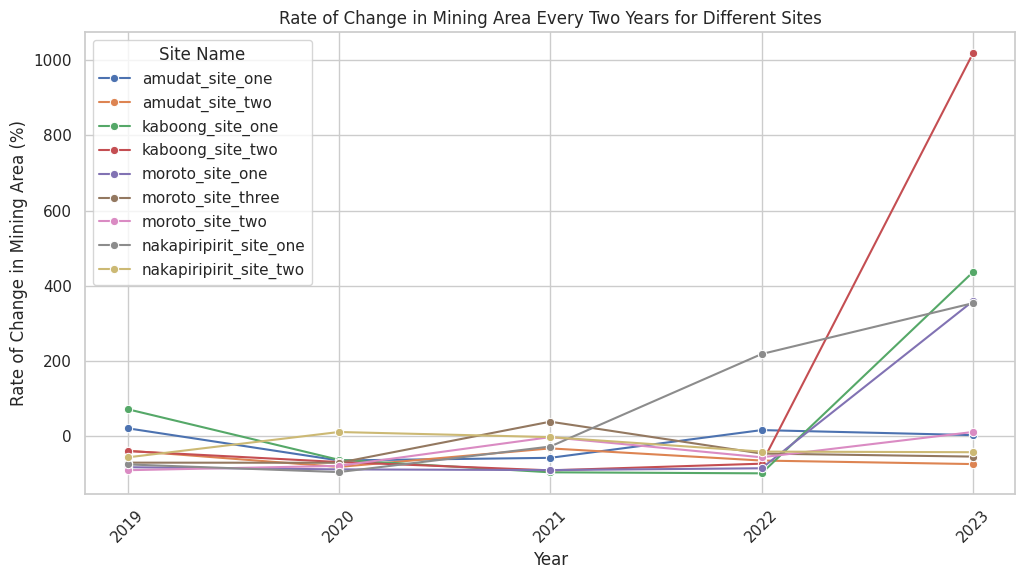

In [ ]:
# Calculate the rate of change every two years
def two_year_pct_change(x):
    return x.pct_change(periods=2) * 100

# Create a new DataFrame to store the rate of change
rate_of_change_df = mining_df.copy()
rate_of_change_df['rate_of_change'] = mining_df.groupby('site_name')['area_ha'].apply(two_year_pct_change).reset_index(level=0, drop=True)

# Plot the rate of change for mining area changes for each site
plt.figure(figsize=(12, 6))
sns.lineplot(data=rate_of_change_df, x='year', y='rate_of_change', hue='site_name', marker='o')
plt.title('Rate of Change in Mining Area Every Two Years for Different Sites')
plt.xlabel('Year')
plt.ylabel('Rate of Change in Mining Area (%)')
plt.legend(title='Site Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
combined_df_go = combined_df_go.reset_index()

# Define the custom color palette
palette = ['green', 'blue', 'red', 'yellow', 'orange', 'magenta']

sns.lineplot(data=combined_df_go, x='Days', y='Area(ha)', hue='Data_source',marker='o', palette=palette)#
plt.xlabel('Day of the year')
plt.ylabel('Area (ha)')
plt.title('Flooded area over time with RS and SAED data (2023 vs 2024)- SAED end of season forecast:39850ha')
plt.legend(title='Data Source')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Create an empty list to store DataFrames for each site
dfs_2015 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year = '2015'  # Change this according to your data
    site_name = site_info['site_name']
    grid_path = site_info['grid_path']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2015.append(df)

# Concatenate all DataFrames into one
combined_df_2015 = pd.concat(dfs_2015, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2015 = combined_df_2015[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2020 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2020"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    # class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    # rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    # process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2020.append(df)

# Concatenate all DataFrames into one
combined_df_2020 = pd.concat(dfs_2020, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2020 = combined_df_2020[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2023 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2023"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2023.append(df)

# Concatenate all DataFrames into one
combined_df_2023 = pd.concat(dfs_2023, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2023 = combined_df_2023[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
combined_df = comb_df_2015.merge(comb_df_2020,how='left').merge(comb_df_2023,how='left')
#combined_df.to_csv(site_path+'combined_lulc_classification.csv')
combined_df

In [ ]:
import re
# Function to create proportions
def create_proportion(rgb_img, data_path, proportion_path, year):
    count_ref_img1 = zonal_stats(data_path, rgb_img, categorical=True)
    stat_df_ = pd.DataFrame(count_ref_img1)
    geogrid = gpd.read_file(data_path)
    # Calculate the total LULC area for each feature
    geogrid['total_lulc_area'] = stat_df_[stat_df_.columns.to_list()[1:]].sum(axis=1)

    geogrid['total_lulc_area'] = geogrid['total_lulc_area'] * 100 * 0.0001

    # Identify columns for the given year
    columnsdate = [col for col in geogrid.columns.to_list()[1:] if str(year) in col]

    # Create a copy of the GeoDataFrame and fill NaN values with 0 for the selected columns
    gdfproportion = geogrid.copy()
    gdfproportion[columnsdate] = gdfproportion[columnsdate].fillna(0)

    # Calculate proportions for each selected column
    for i in columnsdate:
        gdfproportion[i] = gdfproportion[i] / gdfproportion['total_lulc_area']

    # Save the GeoDataFrame with proportions
    gdfproportion.to_file(proportion_path)

    return gdfproportion
def process_tif_file(class_path, rgb_img, grid_path, year):
    grid_data = gpd.read_file(grid_path)
    # Perform zonal statistics to count pixels by class
    ref_image = zonal_stats(grid_path, class_path, categorical=True)
    stat_df = pd.DataFrame(ref_image)
    stat_df = stat_df.sort_index(axis=1)
    #print(stat_df)
    all_possible_cols = [1, 2, 3, 4,5]
    missing_cols = list(set(all_possible_cols) - set(stat_df.columns))

    # Add missing columns with NaN values
    for col_ in missing_cols:
        stat_df[col_] = np.nan

    stat_df = stat_df.sort_index(axis=1)

    # Rename columns with a prefix based on the year
    init_cols = [str(year) + c for c in [ '_treecover', '_other_veg', '_builtup',  '_bare', '_water','_othercls','_mining']]
    stat_df1 = stat_df.rename(columns=dict(zip(stat_df.columns, init_cols)))

    all_col = stat_df1.columns
    stat_df1 = stat_df1[all_col] * 100 * 0.0001
    df = stat_df1
    #print(df.head())

    # Add grid data to the DataFrame
    df[grid_data.columns] = grid_data

    # Add data from "mining," "builtup," and "bareland" and create a new column
    df[f'{year}_mining_builtup'] = df[[f'{year}_mining', f'{year}_builtup']].sum(axis=1)

    # Drop the three individual columns
   # df.drop([f'{year}_mining', f'{year}_builtup', f'{year}_bareland'], axis=1, inplace=True)

    # Convert values to proportions (percentage)
    new_cols = df[[f'{year}_bare', f'{year}_builtup', f'{year}_mining', f'{year}_vegetation', f'{year}_mining_builtup',f'{year}_water']].columns
    #print(new_cols)
    out_path =folder_path+ f'/{site_name}_{year}_classification'
    #Create folders if they don't exist
    create_folder(out_path)
    proportion_path = os.path.join(out_path, "lulc_proportion.geojson")
    operation = 'lulc'
    prop_data = create_proportion(rgb_img, grid_path, proportion_path, year)
    #print(prop_data.head())

    # Add proportions to the DataFrame and calculate proportions
    prop_data[new_cols] = df[new_cols]
    #print(prop_data.columns)
    for i in new_cols:
        prop_data[i] = prop_data[i] / prop_data['total_lulc_area']

    savepath1 = os.path.join(out_path, "dataframe")
    savepath2 = os.path.join(out_path, "dataframe")

    # Create folders if they don't exist
    create_folder(savepath1)
    create_folder(savepath2)

    # Add total LULC area to the DataFrame and save as CSV
    df['total_' + operation + '_area'] = prop_data['total_lulc_area']
    df.to_csv(os.path.join(savepath1, f'lulc_data_{year}.csv'))
    #df.head()
    #df.to_file(os.path.join(savepath1, f'edited_lulc_data_{year}.shp'))
    prop_data.to_csv(os.path.join(savepath2, f'lulc_prop_data_{year}.csv'))
    prop_data.to_file(os.path.join(savepath2, f'lulc_prop_data_{year}.shp'))

# Function to create folders if they don't exist
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Define the list of site paths
site_paths = [
    {'site_name': 'amudat_site_one', 'grid_path': 'Mining_Buffered/Site_Amudat1.geojson', 'folder_path': 'updated_classification/amudat_site_one/'},
    {'site_name': 'amudat_site_two', 'grid_path': 'Mining_Buffered/Site_Amudat2.geojson', 'folder_path': 'updated_classification/amudat_site_two/'},
    {'site_name': 'kaboong_site_one', 'grid_path': 'Mining_Buffered/Site_Kaabong1.geojson', 'folder_path': 'updated_classification/kaboong_site_one/'},
    {'site_name': 'kaboong_site_two', 'grid_path': 'Mining_Buffered/Site_Kaabong2.geojson', 'folder_path': 'updated_classification/kaboong_site_two/'},
    {'site_name': 'moroto_site_one', 'grid_path': 'Mining_Buffered/Site_Moroto1.geojson', 'folder_path': 'updated_classification/moroto_site_one/'},
    {'site_name': 'moroto_site_two', 'grid_path': 'Mining_Buffered/Site_Moroto2.geojson', 'folder_path': 'updated_classification/moroto_site_two/'},
    {'site_name': 'moroto_site_three', 'grid_path': 'Mining_Buffered/Site_Moroto3.geojson', 'folder_path': 'updated_classification/moroto_site_three/'},
    {'site_name': 'nakapiripirit_site_one', 'grid_path': 'Mining_Buffered/Site_Nakapiripirit1.geojson', 'folder_path': 'updated_classification/nakapiripirit_site_one/'},
    {'site_name': 'nakapiripirit_site_two', 'grid_path': 'Mining_Buffered/Site_Nakapiripirit2.geojson', 'folder_path': 'updated_classification/nakapiripirit_site_two/'},
]
site_path = 'updated_classification/'
for year in ['2015', '2020', '2023']:
    # Loop through each site path and process the data
  for site_info in site_paths:
      site_name = site_info['site_name']
      grid_path = site_info['grid_path']
      folder_path = site_info['folder_path']
      class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
      rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
      process_tif_file(class_path, rgb_img, grid_path, year)


# Create an empty list to store DataFrames for each site
dfs_2015 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year = '2015'  # Change this according to your data
    site_name = site_info['site_name']
    grid_path = site_info['grid_path']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2015.append(df)

# Concatenate all DataFrames into one
combined_df_2015 = pd.concat(dfs_2015, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2015 = combined_df_2015[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2020 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2020"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    # class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    # rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    # process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2020.append(df)

# Concatenate all DataFrames into one
combined_df_2020 = pd.concat(dfs_2020, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2020 = combined_df_2020[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2023 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2023"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2023.append(df)

# Concatenate all DataFrames into one
combined_df_2023 = pd.concat(dfs_2023, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2023 = combined_df_2023[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
combined_df = comb_df_2015.merge(comb_df_2020,how='left').merge(comb_df_2023,how='left')
#combined_df.to_csv(site_path+'combined_lulc_classification.csv')
combined_df

,site_name,Latitude,Longitude,geometry,total_lulc_area,2015_bare,2015_builtup_areas,2015_mining,2015_mining_builtup,2015_vegetation,...,2020_mining,2020_mining_builtup,2020_vegetation,2020_water,2023_bare,2023_builtup_areas,2023_mining,2023_mining_builtup,2023_vegetation,2023_water
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",782.39,6.16,15.48,0.33,15.81,750.14,...,11.60,43.31,732.75,0.03,217.09,118.16,293.35,411.51,153.86,0.05
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",861.64,22.15,18.22,2.85,21.07,795.55,...,6.23,27.04,818.18,1.56,550.86,2.42,9.10,11.52,299.12,0.10
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",861.90,NaN,0.01,NaN,0.01,787.95,...,0.77,0.97,711.89,NaN,1.49,0.11,0.19,0.30,860.10,NaN
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",861.59,NaN,0.03,NaN,0.03,556.61,...,NaN,0.05,618.65,NaN,6.60,0.29,5.45,5.74,847.39,1.82
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",861.63,1.77,12.43,0.14,12.57,846.49,...,26.09,35.97,795.41,0.03,307.01,22.81,29.40,52.21,502.32,0.06
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",861.62,0.58,9.62,0.27,9.89,851.11,...,4.51,13.62,842.02,0.10,369.48,16.45,13.86,30.31,461.62,0.18
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",861.63,0.39,22.85,4.46,27.31,798.08,...,14.95,23.04,740.09,NaN,331.81,6.36,7.70,14.06,515.24,0.49
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",861.18,NaN,0.01,NaN,0.01,852.80,...,14.85,17.31,788.27,NaN,5.17,0.06,0.02,0.08,855.80,0.11
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",861.52,0.10,1.80,0.87,2.67,834.01,...,2.37,6.26,847.73,0.98,171.07,19.41,47.38,66.79,622.64,1.02


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
df = combined_df.copy()  # Create a copy to avoid modifying the original DataFrame

# Calculate mining rate between 2015 and 2023
df['mining_rate_2015_2023'] = (df['2023_mining'] - df['2015_mining']) / df['2015_mining']
# Calculate mining rate between 2020 and 2023
df['mining_rate_2020_2023'] = (df['2023_mining'] - df['2020_mining']) / df['2020_mining']
# Calculate mining rate between 2015 and 2023
df['mining_builtup_rate_2015_2023'] = (df['2023_mining_builtup'] - df['2015_mining_builtup']) / df['2015_mining_builtup']
# Calculate mining rate between 2020 and 2023
df['mining_builtup_rate_2020_2023'] = (df['2023_mining_builtup'] - df['2020_mining_builtup']) / df['2020_mining_builtup']
rates_df =df[['site_name', 'Latitude', 'Longitude', 'geometry', 'total_lulc_area', 'mining_rate_2015_2023',
       'mining_rate_2020_2023', 'mining_builtup_rate_2015_2023','mining_builtup_rate_2020_2023']]
rates_df

,site_name,Latitude,Longitude,geometry,total_lulc_area,mining_rate_2015_2023,mining_rate_2020_2023,mining_builtup_rate_2015_2023,mining_builtup_rate_2020_2023
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",782.39,887.939394,24.288793,25.028463,8.501501
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",861.64,2.192982,0.460674,-0.453251,-0.573964
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",861.90,NaN,-0.753247,29.000000,-0.690722
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",861.59,NaN,NaN,190.333333,113.800000
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",861.63,209.000000,0.126869,3.153540,0.451487
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",861.62,50.333333,2.073171,2.064712,1.225404
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",861.63,0.726457,-0.484950,-0.485170,-0.389757
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",861.18,NaN,-0.998653,7.000000,-0.995378
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",861.52,53.459770,18.991561,24.014981,9.669329


In [ ]:
df.columns

Index(['site_name', 'Latitude', 'Longitude', 'geometry', 'total_lulc_area',
       '2015_bare', '2015_builtup_areas', '2015_mining', '2015_mining_builtup',
       '2015_vegetation', '2015_water', '2020_bare', '2020_builtup_areas',
       '2020_mining', '2020_mining_builtup', '2020_vegetation', '2020_water',
       '2023_bare', '2023_builtup_areas', '2023_mining', '2023_mining_builtup',
       '2023_vegetation', '2023_water', 'mining_rate_2015_2023',
       'mining_rate_2020_2023', 'mining_builtup_rate_2015_2023',
       'mining_builtup_rate_2020_2023'],
      dtype='object')

In [ ]:
# Create an empty list to store DataFrames for each site
dfs_2015 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year = '2015'  # Change this according to your data
    site_name = site_info['site_name']
    grid_path = site_info['grid_path']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2015.append(df)

# Concatenate all DataFrames into one
combined_df_2015 = pd.concat(dfs_2015, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2015 = combined_df_2015[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2020 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2020"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    # class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    # rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    # process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2020.append(df)

# Concatenate all DataFrames into one
combined_df_2020 = pd.concat(dfs_2020, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2020 = combined_df_2020[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]


dfs_2023 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2023"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2023.append(df)

# Concatenate all DataFrames into one
combined_df_2023 = pd.concat(dfs_2023, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2023 = combined_df_2023[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
combined_df = comb_df_2015.merge(comb_df_2020,how='left').merge(comb_df_2023,how='left')
#combined_df.to_csv(site_path+'combined_lulc_classification.csv')
combined_df

In [ ]:
comb_df_2015

In [ ]:

dfs_2020 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2020"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    # class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    # rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    # process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2020.append(df)

# Concatenate all DataFrames into one
combined_df_2020 = pd.concat(dfs_2020, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2020 = combined_df_2020[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]

In [ ]:
comb_df_2020


,site_name,Latitude,Longitude,geometry,total_lulc_area,2020_bare,2020_builtup_areas,2020_mining,2020_mining_builtup,2020_vegetation,2020_water
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",782.39,6.42,31.71,11.60,43.31,732.75,0.03
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",861.64,14.82,20.81,6.23,27.04,818.18,1.56
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",861.90,149.03,0.20,0.77,0.97,711.89,NaN
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",861.59,242.85,0.05,NaN,0.05,618.65,NaN
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",861.63,30.19,9.88,26.09,35.97,795.41,0.03
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",861.62,5.85,9.11,4.51,13.62,842.02,0.10
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",861.63,98.47,8.09,14.95,23.04,740.09,NaN
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",861.18,55.58,2.46,14.85,17.31,788.27,NaN
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",861.52,6.55,3.89,2.37,6.26,847.73,0.98


In [ ]:


dfs_2023 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2023"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2023.append(df)

# Concatenate all DataFrames into one
combined_df_2023 = pd.concat(dfs_2023, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2023 = combined_df_2023[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
combined_df = comb_df_2015.merge(comb_df_2020,how='left').merge(comb_df_2023,how='left')
#combined_df.to_csv(site_path+'combined_lulc_classification.csv')
combined_df

,site_name,Latitude,Longitude,geometry,total_lulc_area,2015_bare,2015_builtup_areas,2015_mining,2015_mining_builtup,2015_vegetation,...,2020_mining,2020_mining_builtup,2020_vegetation,2020_water,2023_bare,2023_builtup_areas,2023_mining,2023_mining_builtup,2023_vegetation,2023_water
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",782.39,6.16,15.48,0.33,15.81,750.14,...,11.60,43.31,732.75,0.03,217.09,118.16,293.35,411.51,153.86,0.05
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",861.64,22.15,18.22,2.85,21.07,795.55,...,6.23,27.04,818.18,1.56,550.86,2.42,9.10,11.52,299.12,0.10
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",861.90,NaN,0.01,NaN,0.01,787.95,...,0.77,0.97,711.89,NaN,1.49,0.11,0.19,0.30,860.10,NaN
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",861.59,NaN,0.03,NaN,0.03,556.61,...,NaN,0.05,618.65,NaN,6.60,0.29,5.45,5.74,847.39,1.82
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",861.63,1.77,12.43,0.14,12.57,846.49,...,26.09,35.97,795.41,0.03,307.01,22.81,29.40,52.21,502.32,0.06
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",861.62,0.58,9.62,0.27,9.89,851.11,...,4.51,13.62,842.02,0.10,369.48,16.45,13.86,30.31,461.62,0.18
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",861.63,0.39,22.85,4.46,27.31,798.08,...,14.95,23.04,740.09,NaN,331.81,6.36,7.70,14.06,515.24,0.49
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",861.18,NaN,0.01,NaN,0.01,852.80,...,14.85,17.31,788.27,NaN,5.17,0.06,0.02,0.08,855.80,0.11
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",861.52,0.10,1.80,0.87,2.67,834.01,...,2.37,6.26,847.73,0.98,171.07,19.41,47.38,66.79,622.64,1.02


In [ ]:
# Create an empty list to store DataFrames for each site
dfs_2015 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year = '2015'  # Change this according to your data
    site_name = site_info['site_name']
    grid_path = site_info['grid_path']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2015.append(df)

# Concatenate all DataFrames into one
combined_df_2015 = pd.concat(dfs_2015, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2015 = combined_df_2015[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]

dfs_2020 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2020"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2020.append(df)

# Concatenate all DataFrames into one
combined_df_2020 = pd.concat(dfs_2020, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2020 = combined_df_2020[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
dfs_2023 = []
# Loop through each site path and read the CSV files
for site_info in site_paths:
    year ="2023"
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']
    class_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_class_{year}.tif')
    rgb_img = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    process_tif_file(class_path, rgb_img, grid_path, year)
    csv_path = os.path.join(folder_path, f'{site_name}_{year}_classification/dataframe/lulc_data_{year}.csv')
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path, index_col=0)
    # Add a column for the site name
    df['site_name'] = site_name
    # Append the DataFrame to the list
    dfs_2023.append(df)

# Concatenate all DataFrames into one
combined_df_2023 = pd.concat(dfs_2023, ignore_index=True)

#Optionally, you can select specific columns if needed
comb_df_2023 = combined_df_2023[['site_name','Latitude', 'Longitude', 'geometry','total_lulc_area',
                      f'{year}_bare', f'{year}_builtup_areas', f'{year}_mining',
                      f'{year}_mining_builtup', f'{year}_vegetation', f'{year}_water']]
combined_df = comb_df_2015.merge(comb_df_2020,how='left').merge(comb_df_2023,how='left')
combined_df.to_csv(site_path+'combined_lulc_classification.csv')

In [ ]:
combined_df

,site_name,Latitude,Longitude,geometry,total_lulc_area,2015_bare,2015_builtup_areas,2015_mining,2015_mining_builtup,2015_vegetation,...,2020_mining,2020_mining_builtup,2020_vegetation,2020_water,2023_bare,2023_builtup_areas,2023_mining,2023_mining_builtup,2023_vegetation,2023_water
0,amudat_site_one,1.450433,34.787715,"MULTIPOLYGON (((34.832715 1.450433, 34.8305125...",782.39,6.16,15.48,0.33,15.81,750.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,amudat_site_two,1.925211,34.954624,"MULTIPOLYGON (((34.999624 1.925211, 34.9974215...",861.64,22.15,18.22,2.85,21.07,795.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kaboong_site_one,3.532690,34.273660,"MULTIPOLYGON (((34.31866 3.53269, 34.316457543...",861.90,NaN,0.01,NaN,0.01,787.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kaboong_site_two,3.650640,34.308850,"MULTIPOLYGON (((34.35385 3.65064, 34.351647543...",861.59,NaN,0.03,NaN,0.03,556.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,moroto_site_one,2.405936,34.845722,"MULTIPOLYGON (((34.890722 2.405936, 34.8885195...",861.63,1.77,12.43,0.14,12.57,846.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,moroto_site_two,2.650031,34.662469,"MULTIPOLYGON (((34.707469 2.650031, 34.7052665...",861.62,0.58,9.62,0.27,9.89,851.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,moroto_site_three,2.585147,34.677553,"MULTIPOLYGON (((34.722553 2.585147, 34.7203505...",861.63,0.39,22.85,4.46,27.31,798.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nakapiripirit_site_one,2.030000,34.425500,"MULTIPOLYGON (((34.4705 2.03, 34.4682975432332...",861.18,NaN,0.01,NaN,0.01,852.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,nakapiripirit_site_two,1.920730,34.561800,"MULTIPOLYGON (((34.6068 1.92073, 34.6045975432...",861.52,0.10,1.80,0.87,2.67,834.01,...,2.37,6.26,847.73,0.98,171.07,19.41,47.38,66.79,622.64,1.02


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio

# Define the paths to the RGB and classification TIFF files
rgb_tif_path = "updated_classification/amudat_site_one/amudat_site_one_rgb.tif"
classification_tif_path = "updated_classification/amudat_site_one/amudat_site_one_rf_class_2023.tif"

# Open the RGB and classification TIFF files
with rasterio.open(rgb_tif_path) as rgb_src, rasterio.open(classification_tif_path) as classification_src:
    # Read the RGB image
    rgb_image = rgb_src.read()

    # Read the classification image
    classification_image = classification_src.read(1)  # Assuming it's a single-band image

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Plot the RGB image
    axes[0].imshow(rgb_image.transpose(1, 2, 0))  # Transpose the image to correct the dimensions for display
    axes[0].set_title("RGB Image")
    axes[0].axis('off')

    # Plot the classification image
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
        4: 'green',# Vegetation
        5:'blue' #water
    }
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])
    axes[1].imshow(classification_image, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    axes[1].set_title("Classification")
    axes[1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio

# Define the paths to the RGB and classification TIFF files
rgb_tif_path = "updated_classification/amudat_site_one/amudat_site_one_rgb.tif"
classification_tif_path = "updated_classification/amudat_site_one/amudat_site_one_rf_class_2023.tif"

# Open the RGB and classification TIFF files
with rasterio.open(rgb_tif_path) as rgb_src, rasterio.open(classification_tif_path) as classification_src:
    # Read the RGB image
    rgb_image = rgb_src.read()

    # Read the classification image
    classification_image = classification_src.read(1)  # Assuming it's a single-band image

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Plot the RGB image
    axes[0].imshow(rgb_image.transpose(1, 2, 0))  # Transpose the image to correct the dimensions for display
    axes[0].set_title("RGB Image")
    axes[0].axis('off')

    # Plot the classification image
    class_colors = {
        0: [0, 0, 0],     # Black (for example, for class 0)
        1: 'grey',        # Bare
        2: 'red',         # Built-up areas
        3: 'yellow',      # Mining
        4: 'green',# Vegetation
        5:'blue' #water
    }
    cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])
    axes[1].imshow(classification_image, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    axes[1].set_title("Classification")
    axes[1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
import math
import os

# Define the list of site paths
site_paths = [
    {'site_name': 'amudat_site_one', 'folder_path': 'updated_classification/amudat_site_one/'},
    {'site_name': 'amudat_site_two', 'folder_path': 'updated_classification/amudat_site_two/'},
    {'site_name': 'kaboong_site_one', 'folder_path': 'updated_classification/kaboong_sites/'},
    {'site_name': 'kaboong_site_two', 'folder_path': 'updated_classification/kaboong_sites/'},
    {'site_name': 'moroto_site_one', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'moroto_site_two', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'moroto_site_three', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'nakapiripirit_site_one', 'folder_path': 'updated_classification/nakapiripirit_sites/'},
    {'site_name': 'nakapiripirit_site_two', 'folder_path': 'updated_classification/nakapiripirit_sites/'},
    # Add other site paths similarly
]

# Loop through each site path and plot the images
for site_info in site_paths:
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']

    # Define the paths to the RGB and classification TIFF files
    rgb_tif_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    classification_tif_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_classification.tif')

    # Open the RGB and classification TIFF files
    with rasterio.open(rgb_tif_path) as rgb_src, rasterio.open(classification_tif_path) as classification_src:
        # Read the RGB image
        rgb_image = rgb_src.read()

        # Read the classification image
        classification_image = classification_src.read(1)  # Assuming it's a single-band image

        # Create a figure and axes for plotting
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))

        # Plot the RGB image
        axes[0].imshow(rgb_image.transpose(1, 2, 0))  # Transpose the image to correct the dimensions for display
        axes[0].set_title("RGB Image")
        axes[0].axis('off')

        # Plot the classification image
        class_colors = {
            0: [0, 0, 0],     # Black (for example, for class 0)
            1: 'grey',        # Bare
            2: 'red',         # Built-up areas
            3: 'yellow',      # Mining
            4: 'green'        # Vegetation
        }
        cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])
        axes[1].imshow(classification_image, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
        axes[1].set_title({site_name}_"Classification")
        axes[1].axis('off')

        # Adjust layout
        plt.tight_layout()

        # Save or show plot
        plt.savefig(os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_comparison.png'))
        # plt.show()  # Uncomment this line if you want to display plots interactively without saving
       # plt.close(fig)  # Close the figure to free up memory


In [ ]:
# Login into GEE
import ee
ee.Authenticate()
ee.Initialize(project='ee-janet')

In [ ]:
import geemap

In [ ]:
pwd

In [ ]:
folder_path ='/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/current_data/'
Map = geemap.Map()

# Load study area and classification years
years = ['2015','2020','2023']

# Load classified images and mining buffer
classified = []
images =[]
for year in years:
  class_path = ee.Image(os.path.join(folder_path, f'mining_{year}/classified_rf_{year}_30trees.tif'))
  rgb = ee.Image(os.path.join(folder_path, f'mining_{year}/landsat_rgb_{year}.tif'))
  classified.append(class_path)
  images.append(rgb)
# Display Earth Engine images on the geemap Map
for region, region_name in zip([ classified[0],classified[1],classified[2]],
                               ['rf_class_2015', 'rf_class_2020', 'rf_class_2023']):
  Map.addLayer(region, {'bands': ['classification'], 'min': 1, 'max': 5, 'palette': ["#0b4a04", '#367E18', "#4cff14","#ff0e00", "#fffc62"]}, name=region_name)

In [ ]:
import os
import geopandas as gpd
import geemap
import tempfile

# Define the paths to your TIFF files
site_paths = [{'folder_path': '/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/current_data/', 'grid_path': 'Mining_Buffered/Mining_Buffered.shp'}]

# Load the shapefile into a GeoDataFrame
grid_path = site_paths[0]['grid_path']
buffer_data = gpd.read_file(grid_path)

# Create a temporary file for the GeoDataFrame
with tempfile.TemporaryDirectory() as temp_dir:
    temp_file = os.path.join(temp_dir, 'buffer_data.shp')
    buffer_data.to_file(temp_file)

    # Create an interactive map
    m = geemap.Map()
    m.set_center(34.663752, 2.556330, 11)

    # Loop through each site path and plot the images
    for site_info in site_paths:
        folder_path = site_info['folder_path']
        years = ['2015', "2020", '2023']
        for year in years:
            for idx, geometry in enumerate(buffer_data.geometry):
                # Get the site name for the current polygon
                site_name = buffer_data['Site'].iloc[idx]
                # Define the paths to the RGB and classification TIFF files
                class_path = os.path.join(folder_path, f'mining_{year}/classified_rf_class_{year}.tif')
                rgb_img = os.path.join(folder_path, f'mining_{year}/landsat_rgb_{year}.tif')
                # Add the classification and RGB images as layers
                m.addLayer(class_path, {'bands': ['classification'], 'min': 1, 'max': 5, 'palette': ['grey', 'red', 'orange', 'green', 'blue']}, f'{site_name}_classification_{year}')
                m.add_layer(rgb_img, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.013097499999999984, 'max': 0.16767500000000002},
                            f'{site_name}_landsat_image_{year}')
        # Add the mining buffer layer
        m.add_layer(temp_file, {}, 'Mining Buffer')

# Display the map
m

In [ ]:
folder_path ='/content/gdrive/MyDrive/HEURISTICS/Uganda_predictions/new_mining_sites/current_data/'
Map = geemap.Map()

# Load study area and classification years
years = ['2015','2020','2023']

# Load classified images and mining buffer
classified = []
images =[]
for year in years:
  class_path = ee.Image(os.path.join(folder_path, f'mining_{year}/classified_rf_{year}_30trees.tif'))
  rgb = ee.Image(os.path.join(folder_path, f'mining_{year}/landsat_rgb_{year}.tif'))
  classified.append(class_path)
  images.append(rgb)
  # Open the RGB and classification TIFF files
  with rasterio.open(images[0]) as rgb_src, rasterio.open(classified[0]) as classification_src:
      # Read the RGB image
      rgb_image = rgb_src.read()

      # Read the classification image
      classification_image = classification_src.read(1)  # Assuming it's a single-band image

      # Create a figure and axes for plotting
      fig, axes = plt.subplots(1, 2, figsize=(8, 6))

      # Plot the RGB image
      axes[0].imshow(rgb_image.transpose(1, 2, 0))  # Transpose the image to correct the dimensions for display
      axes[0].set_title(f"RGB Image - {site_name}")
      axes[0].axis('off')

      # Plot the classification image
      class_colors = {
          0: [0, 0, 0],     # Black (for example, for class 0)
          1: 'grey',        # Bare
          2: 'red',         # Built-up areas
          3: 'yellow',      # Mining
          4: 'green',        # Vegetation
          5: 'blue'
      }
      cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])
      im = axes[1].imshow(classification_image, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
      axes[1].set_title(f"Classification - {site_name}")
      axes[1].axis('off')

      # Add colorbar on top of the plots (horizontal)
      cbar = fig.colorbar(im, ax=axes, ticks=range(len(class_colors)), orientation='horizontal', pad=-0.45)
      cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation','water'])

      # Adjust layout
      plt.tight_layout()

      # Save plot
      #plt.savefig(os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_comparison.png'))

      # Display plot
      plt.show()

      # Close the figure to free up memory
      plt.close(fig)


In [ ]:
# # Display Earth Engine images on the geemap Map
# for region, region_name in zip([ classified[0],classified[1],classified[2]],
#                                ['rf_class_2015', 'rf_class_2020', 'rf_class_2023']):

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
import numpy as np
import os

# Define the list of site paths
site_paths = [
    {'site_name': 'amudat_site_one', 'folder_path': 'updated_classification/amudat_site_one/'},
    {'site_name': 'amudat_site_two', 'folder_path': 'updated_classification/amudat_site_two/'},
    {'site_name': 'kaboong_site_one', 'folder_path': 'updated_classification/kaboong_sites/'},
    {'site_name': 'kaboong_site_two', 'folder_path': 'updated_classification/kaboong_sites/'},
    {'site_name': 'moroto_site_one', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'moroto_site_two', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'moroto_site_three', 'folder_path': 'updated_classification/moroto_sites/'},
    {'site_name': 'nakapiripirit_site_one', 'folder_path': 'updated_classification/nakapiripirit_sites/'},
    {'site_name': 'nakapiripirit_site_two', 'folder_path': 'updated_classification/nakapiripirit_sites/'},
    # Add other site paths similarly
]

# Loop through each site path and plot the images
for site_info in site_paths:
    site_name = site_info['site_name']
    folder_path = site_info['folder_path']

    # Define the paths to the RGB and classification TIFF files
    rgb_tif_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rgb.tif')
    classification_tif_path = os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_rf_classification.tif')

    # Open the RGB and classification TIFF files
    with rasterio.open(rgb_tif_path) as rgb_src, rasterio.open(classification_tif_path) as classification_src:
        # Read the RGB image
        rgb_image = rgb_src.read()

        # Read the classification image
        classification_image = classification_src.read(1)  # Assuming it's a single-band image

        # Brighten the RGB image by multiplying the pixel values by a factor (e.g., 1.5)
        brightened_rgb_image = np.clip(rgb_image.astype(float) * 1.5, 0, 255).astype(np.uint8)

        # Create a figure and axes for plotting
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))

        # Plot the brightened RGB image
        axes[0].imshow(brightened_rgb_image.transpose(1, 2, 0))  # Transpose the image to correct the dimensions for display
        axes[0].set_title(f"Brightened RGB Image - {site_name}")
        axes[0].axis('off')

        # Plot the classification image
        class_colors = {
            0: [0, 0, 0],     # Black (for example, for class 0)
            1: 'grey',        # Bare
            2: 'red',         # Built-up areas
            3: 'yellow',      # Mining
            4: 'green',        # Vegetation
            5: 'blue'        # Vegetation
        }
        cmap = mcolors.ListedColormap([class_colors[x] for x in sorted(class_colors.keys())])
        im = axes[1].imshow(classification_image, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
        axes[1].set_title(f"Classification - {site_name}")
        axes[1].axis('off')

        # Add colorbar on top of the plots (horizontal)
        cbar = fig.colorbar(im, ax=axes, ticks=range(len(class_colors)), orientation='horizontal', pad=-0.45)
        cbar.ax.set_xticklabels(['nodata', 'bare', 'builtup areas', 'mining', 'vegetation'])

        # Adjust layout
        plt.tight_layout()

        # Save plot
        plt.savefig(os.path.join(folder_path, f'{site_name.lower().replace(" ", "_")}_comparison.png'))

        # Display plot
        plt.show()

        # Close the figure to free up memory
        plt.close(fig)
